In [1]:

import pandas as pd
import numpy as np
import random
import pylab as pl
import time
import datetime
from sklearn.feature_selection import RFECV

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
# scikit learning packages
from lightgbm import LGBMRegressor, early_stopping
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    KFold,
    StratifiedKFold,
    GridSearchCV
)
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
    VotingRegressor
)
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder,
    PolynomialFeatures,
    scale
)
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    LogisticRegressionCV,
    LogisticRegression
)
from sklearn.svm import SVC
from sklearn import svm, metrics, tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample, shuffle

from collections import Counter
from pandas.api.types import is_numeric_dtype
import holidays
import warnings
from scipy.stats.mstats import mquantiles
from scipy.stats import skew
warnings.filterwarnings("ignore")
cmap = sns.color_palette('Blues_r')


###################################
starting_time = time.perf_counter()
print('')
print('starting time: ', datetime.datetime.now().strftime("%H:%M:%S"))
print('')
###################################

### Read the file
df_raw = pd.read_excel("ML_Absenteism.xlsx")


##########
ending_time = time.perf_counter()
total_in_sec = ending_time-starting_time
print("Data time in sec")
print(total_in_sec)
print("Data uploaded")


starting time:  12:42:59

Data time in sec
72.5959234
Data uploaded


# 📊 Introduction to Our Columns and Their Data Types

The dataset contains **185,068 entries** with a total of **32 columns**. Below is the overview of the columns, their non-null counts, and data types:

### 🗂️ Data Types Summary:
- **datetime64[ns]**: 3 columns
- **float64**: 12 columns
- **int64**: 4 columns
- **object**: 13 columns

This structure helps us identify **missing values**, the **nature of each column**, and how we can handle the data effectively during preprocessing.

In [2]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185068 entries, 0 to 185067
Data columns (total 32 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            185068 non-null  datetime64[ns]
 1   AssignedDep     185068 non-null  int64         
 2   MU_Name         185068 non-null  object        
 3   Country         184984 non-null  object        
 4   Language        184477 non-null  object        
 5   Location Type   132733 non-null  object        
 6   Manager ID      171455 non-null  float64       
 7   Role            183992 non-null  object        
 8   dob             184411 non-null  datetime64[ns]
 9   sex             185068 non-null  object        
 10  marital_status  185068 non-null  object        
 11  hire_date       185068 non-null  datetime64[ns]
 12  CCMS_ID         185068 non-null  int64         
 13  c_excp          185068 non-null  object        
 14  c_name_y        185068 non-null  obj

# 📊 Dataset Overview

The dataset is part of the **Western Union Project**, selected for testing **predictive absenteeism models**. It spans the date range **2023-01-01 to 2025-01-23**, with data fetched from **ScheleV3**, a system used to track historical employee metrics. 

Additional features such as **dob**, **sex**, **marital_status**, **hire_date**, **Is_Actual**, and **Is_Strike** have been introduced to enrich the dataset.

---

## 🔑 Key Features

### 📅 **Date Columns:**
- **Date**, **dob**, and **hire_date** provide chronological information essential for calculating:
  - Employee **tenure**
  - Employee **age**

### 🗂️ **Categorical Data:**
- Fields like:
  - **MU_Name** (Management Unit)
  - **Country**
  - **Language**
  - **Role**
  - **sex**
  - **marital_status**
  
  These describe **employee demographics** and **organizational roles**.

### 🔢 **Numerical Data:**
- Columns such as:
  - **AssignedDep**
  - **Contract Hours**
  - **Scheduled**
  - **Worked**
  - **Rest**
  - **Overtime**
  - **Absence**
  - **Sick**
  
  These capture **time-related work metrics** and serve as **features or targets** for absenteeism predictions.

### 🧮 **Derived Features:**
- New columns like:
  - **Is_Actual** *(Actual or Forecast)*
  - **Is_Strike** *(Strike day or not)*
  - Calculated fields:
    - **Age**
    - **Tenure_Company**
    - **Tenure_Department**
  
  These provide **deeper insights** for modeling.

---

## ❗ Missing Data

Significant missing values are found in the following columns:
- **Country**
- **Language**
- **Location Type**
- **Manager ID**
- **Role**
- **Contract Hours**

These require specific **imputation strategies** to handle missing data effectively.

---

## 🔍 Sample Insights

### 🗓️ **Potential Predictive Features Include:**

1. **Temporal Aspects:**
   - **Date**
   - **Shift_Starts**
   - **DayofWeek**
   - **Season**

2. **Employee Demographics:**
   - **dob**
   - **sex**
   - **marital_status**

3. **Work Metrics:**
   - **Scheduled**
   - **Worked**
   - **Overtime**
   - **Training**
   - **Vacation**
   - **Sick**
   - **Total_Lost**
   - **Absence**
   - **Early**
   - **Late**

---

## 🚀 Notable Enhancements

### ✨ **Feature Additions:**
- **Demographic Features:** 
  - **dob**, **sex**, and **marital_status**
- **Derived Fields:** 
  - **Age**
  - **Is_Holiday**
  - **Tenure_Department**

These enrich the dataset with **additional dimensions** for predictive analysis.

### 🔧 **Imputation Strategies:**
- **Missing Dates & Numeric Values:** 
  - Filled using **forward/backward filling** and **averages**.
- **Group-level Imputation:** 
  - Applied to columns like **Manager ID** for more accurate filling.

---

This comprehensive overview provides a solid foundation for understanding the dataset and preparing it for **predictive modeling**. 📈


In [3]:
###################################
starting_time = time.perf_counter()
print('')
print('starting time: ', datetime.datetime.now().strftime("%H:%M:%S"))
print('')
###################################

df = df_raw.copy()

# -----------------------
# Drop Duplicates
# -----------------------
df = df.drop_duplicates(subset=['CCMS_ID','Date'], keep='first')

# -----------------------
# Handle Missing Age
# -----------------------
avg_dob = df['dob'].mean()
avg_dh = df['hire_date'].mean()
# Fill missing dob with the average dob
df['hire_date'].fillna(avg_dh, inplace=True)

df['dob'].fillna(avg_dob, inplace=True)
df['Age'] = (df['Date'] - df['dob']).dt.days // 365

# -----------------------
# Identify columns with null, excluding 'dob'
# -----------------------
columns_with_null = df.columns[df.isna().any()].tolist()

print("Columns with missing values \n", columns_with_null)

# -----------------------
# Helper function to fill missing values for one column in one group
# -----------------------
def fill_missing_for_column(g, col):
    # If the column has no missing values in this group, do nothing
    if g[col].isna().sum() == 0:
        return g

    # Earliest date with a null in this column
    minnull = g.loc[g[col].isna(), 'Date'].min()

    # Earliest date with a non-null in this column
    minnotnull = g.loc[g[col].notna(), 'Date'].min()

    # Forward or backward fill based on minnull vs minnotnull
    if pd.notna(minnull) and pd.notna(minnotnull):
        if minnull > minnotnull:
            g[col] = g[col].bfill()
        else:
            g[col] = g[col].ffill()

    # Fill remaining null with 0 or 'Unknown'
    if is_numeric_dtype(g[col]):
        g[col] = g[col].fillna(0)
    else:
        g[col] = g[col].fillna('Unknown')

    return g

# -----------------------
# Apply per column and per group
# -----------------------
for col in columns_with_null:
    print(f"Handling missing values for {col}")
    df = (
        df
        .groupby('CCMS_ID', group_keys=False)
        .apply(lambda group: fill_missing_for_column(group, col))
    )

# Done.

conditions = [
    df['Role'].isin(['CSS', 'Operations Customer Expert I', 'Operations Customer Expert II']),
    df['Role'].isin(['Supervisor', 'Operations Supervisor', 'Flex Supervisor']),
    df['Role'].isin(['CCM', 'Operations Manager']),
    df['Role'].isin(['ACM', 'Operations Assistant Manager']),
    df['Role'].str.contains('Flex QA Analyst|QA|Quality', case=False, na=False),
    df['Role'].str.contains('WFM', case=False, na=False),
    df['Role'] == 'Unknown'
]

choices = ['CSS', 'Supervisor', 'CCM', 'ACM', 'QA', 'WFM', 'Unknown']

# Apply the mapping logic
df['Role'] = np.select(conditions, choices, default='Unknown')



df['Country'] = df['Country'].str.replace('Unknown','Greece')

df = df.sort_values(by=['CCMS_ID','Date']).reset_index(drop=True)


df['Department_hire_date'] = df.groupby('CCMS_ID')['Date'].transform('min')
df['Tenure_Company'] = (df['Date'] - df['hire_date']).dt.total_seconds() / 3600
df['Tenure_Departmant'] = (df['Date'] - df['Department_hire_date']).dt.total_seconds() / 3600

df['Manager ID'] = df['Manager ID'].astype(int).astype(str)
df['Contract Hours'] = df['Contract Hours'].astype(int).astype(str)
df['AssignedDep'] = df['AssignedDep'].astype(int).astype(str)

df['Rest'] = df['Rest'].apply(lambda x: 0 if x < 0 else (100 if x > 100 else x))
## Bucketizer 

def bucketizer(x):
    if x < 30:
        return 'NH'
    elif 30 <= x < 60:
        return '01mos'
    elif 60 <= x < 90:
        return '02mos'
    elif 90 <= x < 180:
        return '03mos'
    elif 180 <= x < 365:
        return '06Mos'
    elif 365 <= x < 730:
        return '1Year'
    elif 730 <= x < 1825:
        return '2-5Years'
    else:
        return '+5Year'
df['Tenure_Company'] = df['Tenure_Company'].apply(bucketizer)
df['Tenure_Departmant'] = df['Tenure_Departmant'].apply(bucketizer)

def age_bucketizer(x):
    if x < 25:
        return '18-25'
    elif 25 <= x < 30:
        return '25-30'
    elif 30 <= x < 35:
        return '30-35'
    elif 35 <= x < 40:
        return '35-40'
    elif 40 <= x < 45:
        return '40-45'
    elif 45 <= x < 50:
        return '45-50'
    else:
        return '+50'
df['Age'] = df['Age'].apply(age_bucketizer)


# ## Drop columns 
df = df.drop(columns=[ 'dob', 'hire_date', 'Department_hire_date'])

# Generate the dictionary by passing each unique country name to holidays.country_holidays
country_to_code = {}

for country in df['Country'].unique():
    try:
        iso_code = holidays.country_holidays(country=country).country
        country_to_code[country] = iso_code
    except Exception as e:
        print(f"Error for country: {country} - {e}")

# Function to check if a date is a holiday
def is_holiday(row):
    country_code = country_to_code.get(row['Country'])
    if country_code:
        try:
            country_holidays = holidays.country_holidays(country=country_code, years=row['Date'].year)
            return '1' if row['Date'] in country_holidays else '0'
        except Exception as e:
            print(f"Error checking holiday for {row['Country']} on {row['Date']}: {e}")
    return 0

# Apply the function to create the Is_Holiday column
df['Is_Holiday'] = df.apply(is_holiday, axis=1)

### Create extra Date columns 

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['WeekofYear'] = df['Date'].dt.isocalendar().week
df['DayofMonth'] = df['Date'].dt.day
df['DayofWeek'] = df['Date'].dt.dayofweek
df['Season'] = (df['Date'].dt.month % 12 + 3) // 3

df['Total_Lost'] = df['Absence'] 
df['Absence'] = df['Total_Lost']-(df['Early']+df['Late'])
##########
ending_time = time.perf_counter()
total_in_sec = ending_time-starting_time
print("\n Data time in sec")
print(total_in_sec)
print("Data Cleaning Completed")


starting time:  12:44:12

Columns with missing values 
 ['Country', 'Language', 'Location Type', 'Manager ID', 'Role', 'Contract Hours']
Handling missing values for Country
Handling missing values for Language
Handling missing values for Location Type
Handling missing values for Manager ID
Handling missing values for Role
Handling missing values for Contract Hours

 Data time in sec
51.457887
Data Cleaning Completed


# 📊 Cramér's V Analysis

### 🔍 **What is Cramér's V?**

Cramér's V is a **statistical measure** used to **quantify the strength of association** between two **categorical variables**. It is based on the **chi-squared statistic** and provides a **normalized value between 0 and 1**:

- **0** → Indicates **no association** between the variables.
- **1** → Indicates a **perfect association**.

Cramér's V is particularly useful for understanding relationships between **categorical features**, which **cannot be analyzed** using traditional correlation methods like **Pearson's correlation** (used for numerical data).

---

## 🤔 **Why Implement Cramér's V in Analysis?**

### 1️⃣ **Feature Selection:**
- Identify **strong associations** between **independent categorical features** and the **target variable** (e.g., **Absence** or **Sick**).
- Highlight **highly correlated categorical features** to **avoid redundancy** in the model.

### 2️⃣ **Data Understanding:**
- Reveal how variables like **Role**, **Language**, or **Country** interact with each other or with the **target feature**.
- Help decide whether features need **grouping**, **transformation**, or **encoding**.

### 3️⃣ **Improving Model Interpretability:**
- Selecting **meaningful features** ensures that **relationships identified by the model** are **relevant** and **interpretable** for stakeholders.

---

## ⚙️ **Implementation in Analysis**

### ✅ **1. Compute the Chi-Squared Statistic:**
- A **contingency table** is created for the two categorical variables.
- The **chi-squared test** is performed on this table to measure **independence**.

### ✅ **2. Normalize the Chi-Squared Value:**

Cramér's V is calculated as:

\[
V = \sqrt{\frac{\chi^2}{N \cdot (k - 1)}}
\]

Where:
- **\(\chi^2\)** = Chi-squared statistic  
- **N** = Total number of observations  
- **k** = Minimum of the number of categories in the two variables  

### ✅ **3. Use the Results:**
- Variables with **high Cramér's V values** (e.g., **> 0.3**) show **strong associations** and are considered **impactful** for the analysis.
- Features with **low Cramér's V values** may have **weak or no association** and can potentially be **excluded**.

---

## 📊 **Example Use Case in Predictive Absenteeism**

In the **ML_Absenteeism** dataset:

- **Analyzing the relationship** between **Role** and **Absence** might reveal how certain **job roles** (e.g., **Supervisor** vs. **CSS**) **correlate with absenteeism rates**.
- Similarly, checking the **association between Country and Language** can help uncover if they are **highly redundant**, guiding decisions on **encoding** or **grouping**.

---

## 🚀 **Why It Matters?**

By implementing **Cramér's V**, we can:

- 🎯 **Reduce Dimensionality:**  
  Avoid **multicollinearity** and **redundant features**, improving **model performance**.

- ⚡ **Improve Efficiency:**  
  Focus on features with **meaningful associations**, simplifying **preprocessing** and reducing **computation time**.

- 📈 **Increase Accuracy:**  
  Use the **most relevant categorical features**, enhancing the model's **predictive power**.

---

This method is a **powerful tool** for ensuring that our **predictive models** are both **efficient** and **accurate** when working with **categorical data**. ✅


# Cramér's V analysis for Categorical feature

In [4]:
# Define the column groups
cramers_v_cols = [
    'Is_Holiday', 'Year', 'Season', 'Month', 'WeekofYear', 'DayofMonth',
    'DayofWeek', 'AssignedDep', 'MU_Name', 'Country', 'Language', 'Location Type',
    'Manager ID', 'Role', 'sex', 'Age', 'marital_status', 'Tenure_Company',
    'Tenure_Departmant', 'c_excp', 'c_name_y','Is_Strike', 'Shift','Shift_Starts','Shift_Code', 'Contract Hours'
]

columns_to_count = ['CCMS_ID']
columns_to_sum = ['Scheduled', 'Worked', 'Overtime', 'Training', 'Vacation', 'Sick','Total_Lost','Absence', 'Early', 'Late']
columns_to_mean = ['Rest', 'BreakLunch']

# Combine all necessary columns
crmcols = cramers_v_cols + columns_to_count + columns_to_sum + columns_to_mean
creamar_numeric = columns_to_count + columns_to_sum + columns_to_mean
dfg = df[df['Is_Actual']=='Actual'][crmcols]  # Ensure only relevant columns are selected

# Prepare the aggregation dictionary
agg_dict = {col: 'count' for col in columns_to_count}  # Count for CCMS_ID
agg_dict.update({col: 'sum' for col in columns_to_sum})  # Sum for numeric metrics
agg_dict.update({col: 'mean' for col in columns_to_mean})  # Mean for averages

# Group by cramers_v_cols and apply the aggregation
dfg = (
    df.groupby(cramers_v_cols)
    .agg(agg_dict)
    .reset_index()
)

# Ensure cramers_v_cols are treated as strings for consistency
for strcol in cramers_v_cols:
    dfg[strcol] = dfg[strcol].astype(str)

# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Initialize an empty DataFrame to store the results
results = []

# Loop through each column in cramers_v_cols
for cat_col in cramers_v_cols:
    for num_col in creamar_numeric:
        try:
            # Calculate Cramér's V
            score = cramers_v(dfg[cat_col], dfg[num_col])
            results.append({
                'Categorical Feature': cat_col,
                'Numeric Feature': num_col,
                'Cramers_V': score
            })
        except Exception as e:
            # Handle cases where calculation fails
            results.append({
                'Categorical Feature': cat_col,
                'Numeric Feature': num_col,
                'Cramers_V': np.nan,
                'Error': str(e)
            })

# Convert results to DataFrame
df_cramers_v = pd.DataFrame(results)

# Add association categories
df_cramers_v['Association'] = pd.cut(
    df_cramers_v['Cramers_V'], 
    bins=[-np.inf, 0, 0.2, 0.3, 0.5, np.inf],
    labels=['No association', 'Weak association', 'Moderate association', 
            'Relatively strong association', 'Strong association']
)

df_cramers_v=df_cramers_v[df_cramers_v['Cramers_V'].isna()==False]
# Display the results
df_cramers_v=df_cramers_v.sort_values(by=['Cramers_V'],ascending=[False]).reset_index(drop=True)

df_cramers_v.head(30)

,Categorical Feature,Numeric Feature,Cramers_V,Association
0,Shift,Overtime,0.718001,Strong association
1,c_excp,Rest,0.706045,Strong association
2,c_excp,Scheduled,0.622988,Strong association
3,c_excp,Worked,0.595620,Strong association
4,Contract Hours,Scheduled,0.564758,Strong association
5,Shift_Starts,Rest,0.528850,Strong association
6,Contract Hours,Worked,0.506457,Strong association
7,c_excp,BreakLunch,0.484534,Relatively strong association
8,Shift_Starts,Scheduled,0.435912,Relatively strong association
9,Shift_Starts,Worked,0.413216,Relatively strong association


# Association Category

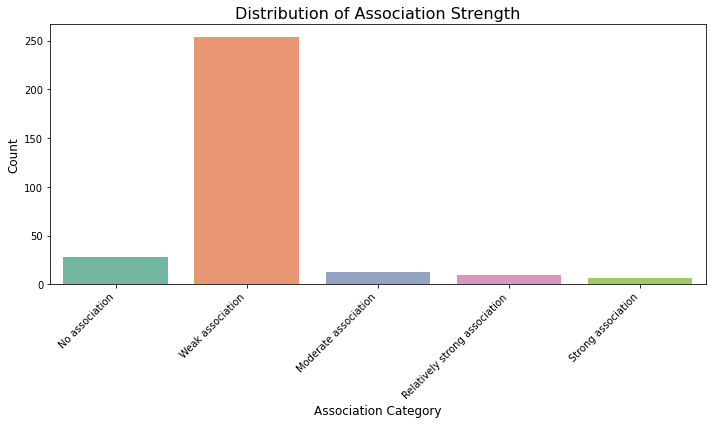

In [5]:
plt.figure(figsize=(10, 6))  # Increase figure width
sns.countplot(data=df_cramers_v, x="Association", palette="Set2")
plt.title("Distribution of Association Strength", fontsize=16)
plt.xlabel("Association Category", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Rotate x-labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Ensure everything fits within the figure
plt.show()

# 📊 Observations on the Distribution of Association Strength

### 🔍 **Key Observations**

As observed from the **distribution chart**, the majority of our **categorical fields** exhibit a **weak association** with the **target KPIs**. While these associations primarily fall under the **"Weak" category**, it is still valuable to explore these relationships further.

---

## 💡 **Why Weak Associations Matter**

- **Hidden Insights:**  
  Understanding the **dynamics** between **categorical** and **numerical fields** can **uncover hidden patterns** that may not be immediately obvious.

- **Model Interpretability:**  
  Even weak associations can **improve the interpretability** of the model, providing **contextual understanding** for stakeholders.

- **Combined Impact:**  
  **Weak associations** may hold **significant value** when combined with other variables, contributing to **interaction effects** that are critical in predictive modeling.

---

## 🚀 **The Importance of In-Depth Analysis**

- **Data Enrichment:**  
  Analyzing these relationships helps identify **potential areas for data enrichment**, enabling the creation of **new features** that capture more nuanced behaviors.

- **Feature Engineering:**  
  Insights gained can drive **feature engineering efforts**, such as:
  - **Grouping categories** with similar behaviors
  - **Encoding strategies** for categorical variables
  - **Interaction terms** for modeling complex relationships

---

## 📈 **Impact on Model Performance**

This effort can ultimately:

- **Enhance Predictive Power:**  
  By capturing **subtle associations**, we can improve the **accuracy** of our predictions.

- **Improve Model Robustness:**  
  Understanding all relationships, even weak ones, contributes to a **more resilient** model capable of handling diverse data scenarios.

---

> 🔑 **Conclusion:**  
While weak associations may seem insignificant at first glance, their **combined influence** and **contextual importance** can play a crucial role in **optimizing predictive models**. Therefore, a **comprehensive analysis** is essential for achieving the best results.

# Cramér's V Heatmap

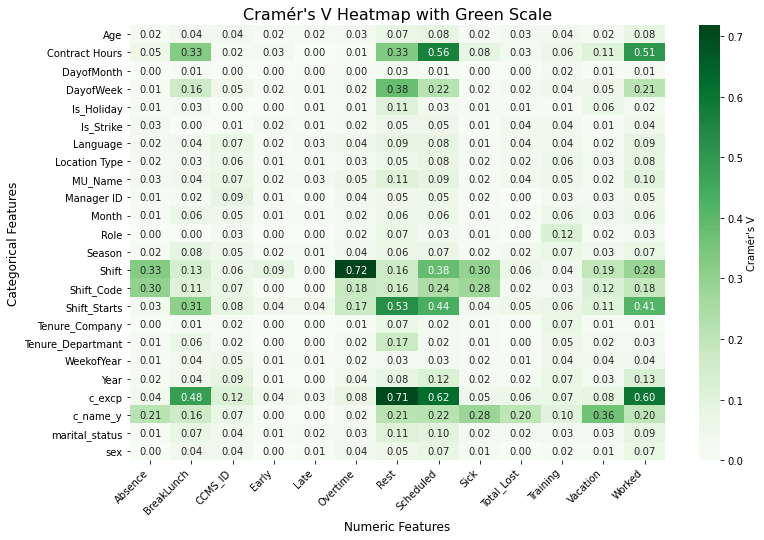

In [6]:
# Pivot the data for heatmap
heatmap_data = df_cramers_v.pivot("Categorical Feature", "Numeric Feature", "Cramers_V")

# Plot the heatmap with the green color scale
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".2f", 
    cmap="Greens",  # Lighter to darker green colormap
    cbar_kws={'label': "Cramér's V"}
)
plt.title("Cramér's V Heatmap with Green Scale", fontsize=16)
plt.xlabel("Numeric Features", fontsize=12)
plt.ylabel("Categorical Features", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

In [7]:
df_cramers_v= df_cramers_v[(df_cramers_v['Cramers_V']>=0.3)
                          &(df_cramers_v['Numeric Feature']!='Rest')]
Association_Features = list(df_cramers_v['Categorical Feature'].unique())

# 🚀 **Feature Selection Based on Association Analysis**

### 📊 **Key Findings from the Analysis**

From our analysis, we have identified that **most of the categorical features exhibit little to no association** with **Total_Lost**. 

To **improve model efficiency** and **focus on features with meaningful contributions**, we will:

- ❌ **Exclude** non-associated categorical features from the model.
- ✅ **Retain** categorical features with reasonable associations, as identified in the **`Association_Features`** variable.

---

## 🎯 **Retained Features**

### ✅ **Features with Strong Associations:**
- The categorical features listed in the **`Association_Features`** variable show a **reasonable level of association** with **Total_Lost**. 
- These features will be **retained** to ensure the model captures important **patterns** related to absenteeism.

### 📋 **Operationally Relevant Features:**
In addition to the association-based features, we will also include **essential categorical features** such as:
- **MU_Name** (Management Unit)
- **Language**
- Other **operationally relevant attributes** that are critical for maintaining key **business requirements**.

---

## 🚀 **Why This Approach?**

- **Optimized Model Performance:**  
  By excluding irrelevant features, we reduce **noise** and improve the model’s **predictive power**.

- **Improved Efficiency:**  
  A **leaner feature set** means faster **training times** and **reduced computational costs**.

- **Enhanced Interpretability:**  
  Focusing on features with **clear associations** makes the model’s predictions more **understandable** and **actionable** for stakeholders.

- **Business Relevance:**  
  Including operationally important features ensures the model aligns with **real-world business needs**.

---

> 💡 **Conclusion:**  
By refining our feature set in this manner, we aim to **optimize the model’s performance** while maintaining a **comprehensive understanding** of the data. This balanced approach supports both **technical efficiency** and **business relevance**.


In [8]:
print(Association_Features)
df_cramers_v

['Shift', 'c_excp', 'Contract Hours', 'Shift_Starts', 'c_name_y']


,Categorical Feature,Numeric Feature,Cramers_V,Association
0,Shift,Overtime,0.718001,Strong association
2,c_excp,Scheduled,0.622988,Strong association
3,c_excp,Worked,0.595620,Strong association
4,Contract Hours,Scheduled,0.564758,Strong association
6,Contract Hours,Worked,0.506457,Strong association
7,c_excp,BreakLunch,0.484534,Relatively strong association
8,Shift_Starts,Scheduled,0.435912,Relatively strong association
9,Shift_Starts,Worked,0.413216,Relatively strong association
10,Shift,Scheduled,0.382836,Relatively strong association
12,c_name_y,Vacation,0.364851,Relatively strong association


# Cramér's V Bar Plots 

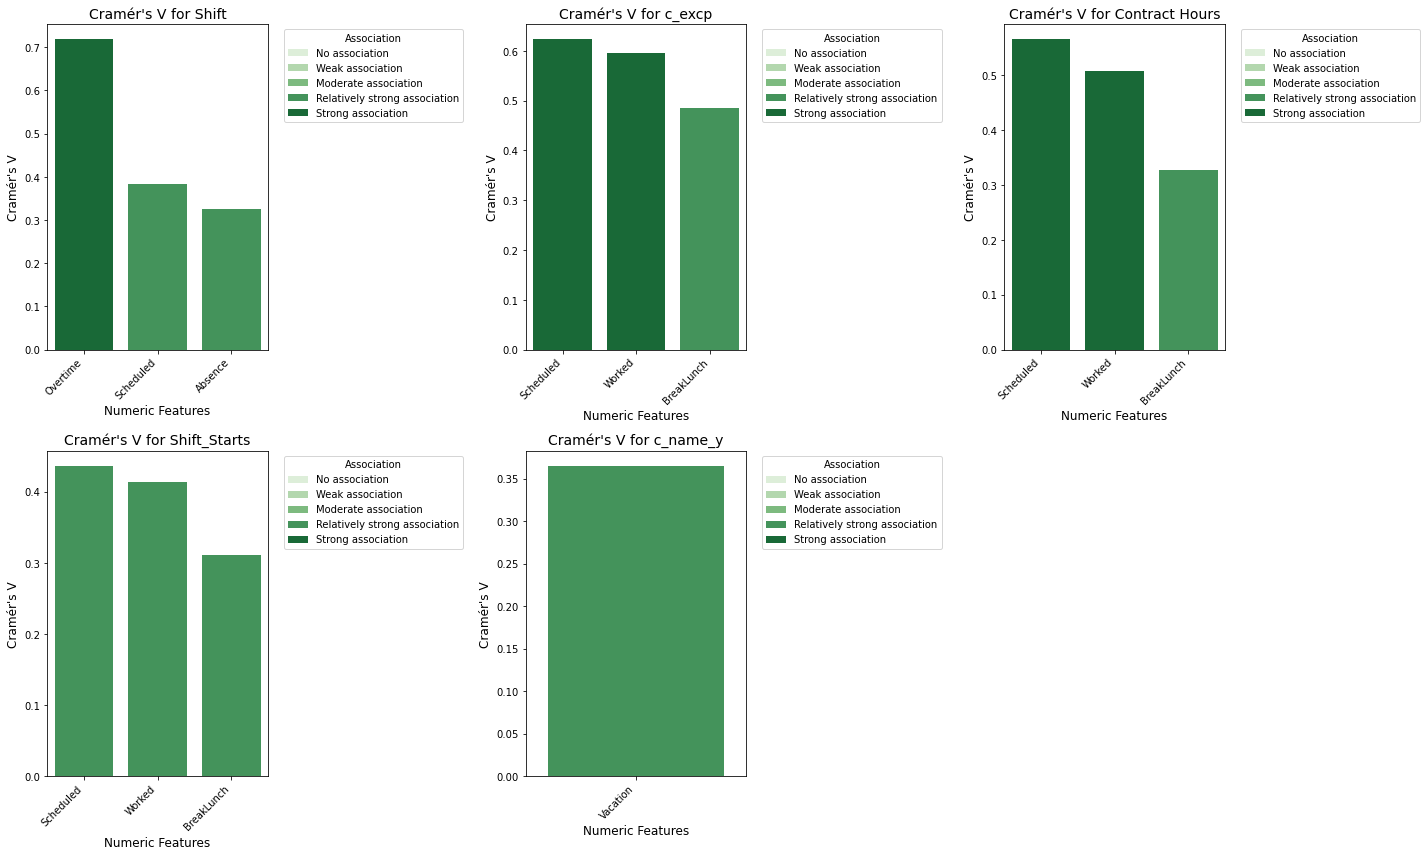

In [9]:
# List of unique categorical features
unique_categorical_features = df_cramers_v['Categorical Feature'].unique()

# Set the number of rows and columns for the subplots
num_features = len(unique_categorical_features)
cols = 3  # Number of plots per row
rows = (num_features + cols - 1) // cols  # Calculate required rows

# Set the figure size
plt.figure(figsize=(20, rows * 6))

# Iterate through each categorical feature and create a bar plot
for i, feature in enumerate(unique_categorical_features):
    filtered_data = df_cramers_v[df_cramers_v['Categorical Feature'] == feature]
    
    plt.subplot(rows, cols, i + 1)
    sns.barplot(
        data=filtered_data, 
        x="Numeric Feature", 
        y="Cramers_V", 
        hue="Association", 
        dodge=False, 
        palette="Greens"  # Lighter to darker green
    )
    plt.title(f"Cramér's V for {feature}", fontsize=14)
    plt.xlabel("Numeric Features", fontsize=12)
    plt.ylabel("Cramér's V", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Association", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# 📊 **Refining Feature Selection Based on Association Strength**

### 🔍 **Key Observations**

After filtering for only the following levels of association:

- **Moderate Association**
- **Relatively Strong Association**
- **Strong Association**

…and **excluding the rest of the numerical values**, we observed that:

- ✅ Only **five categorical features** showed a **moderate or higher association** with our **numerical KPIs**.
- ❌ However, **almost none of these features demonstrated a direct impact** on **absenteeism**.

---

## ⚠️ **Implications of the Findings**

- **Limited Direct Impact:**  
  While these features may show statistical associations with other numerical KPIs, they **do not directly influence absenteeism**, which is the core focus of our predictive model.

- **Potential Indirect Effects:**  
  Despite the lack of a direct impact, some features might still play an **indirect role** through interactions with other variables. Hence, further analysis may be warranted in specific cases.

- **Feature Re-evaluation:**  
  This finding prompts us to **re-evaluate the importance** of certain features, ensuring that we prioritize variables with **actual predictive power** for absenteeism.

---

## 🚀 **Next Steps**

1. **Exclude Non-Impactful Features:**  
   - Remove categorical features that lack a **direct association** with absenteeism to **enhance model efficiency**.

2. **Focus on Impactful Variables:**  
   - Retain features with **clear, measurable impacts** on absenteeism.

3. **Explore Interactions:**  
   - For features with **moderate associations**, consider exploring **interaction effects** with other variables to uncover **hidden patterns**.

---

> 💡 **Conclusion:**  
This process ensures that our model remains **focused**, **efficient**, and **aligned** with the goal of accurately predicting absenteeism while avoiding the inclusion of **irrelevant features**.


#  Grouped Bar Plot for All Categorical Features

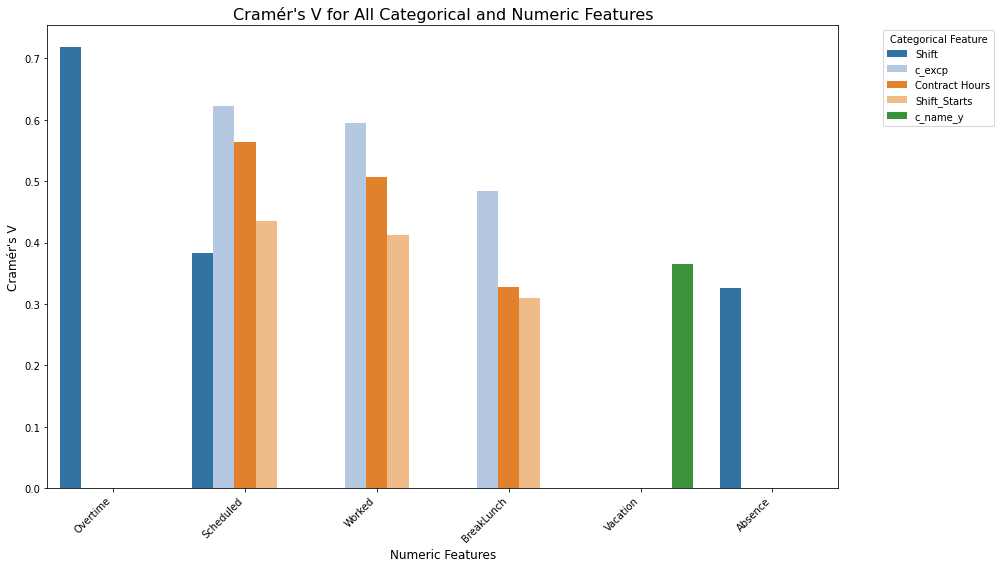

In [10]:
# Grouped bar plot for all categorical features
plt.figure(figsize=(14, 8))
sns.barplot(data=df_cramers_v, x="Numeric Feature", y="Cramers_V", hue="Categorical Feature", dodge=True, palette="tab20")
plt.title("Cramér's V for All Categorical and Numeric Features", fontsize=16)
plt.xlabel("Numeric Features", fontsize=12)
plt.ylabel("Cramér's V", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Categorical Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# 📊 **Pearson and Spearman Correlation Coefficients**

---

## 🔍 **Overview and Why They're Important**

When analyzing data for **predictive modeling**, **Pearson** and **Spearman correlation coefficients** are used to evaluate the relationships between **numerical features**. 

Here’s a breakdown of their purpose, differences, and why they are vital in data analysis:

---

## 📈 **Pearson Correlation Coefficient**

### ✅ **1. What It Measures:**
- Pearson’s correlation coefficient (**r**) quantifies the **linear relationship** between two continuous variables.
- It ranges from:
  - **-1** → Perfect **negative** linear relationship
  - **0** → **No** linear relationship
  - **1** → Perfect **positive** linear relationship

### ⚡ **2. Use Case:**
- Ideal for **numerical data** that has a **linear relationship**.
- **Example in Absenteeism Dataset:**  
  - Exploring the correlation between **Scheduled** and **Worked** hours.

### 💡 **3. Why It's Used:**
- Identifies **highly correlated numerical features**, which may cause **multicollinearity** and reduce model performance.
- Helps decide which features to **retain** or **drop** during feature engineering.

---

## 📊 **Spearman Correlation Coefficient**

### ✅ **1. What It Measures:**
- Spearman’s correlation coefficient (**ρ**) measures the **rank-order relationship** between two variables.
- Unlike Pearson, it does **NOT assume linearity** but focuses on **monotonic relationships** (increasing or decreasing trends).
- Also ranges from **-1** to **1**.

### ⚡ **2. Use Case:**
- Useful for numerical data with **non-linear but monotonic relationships**.
- **Example in Absenteeism Dataset:**
  - **Age vs. Absence:** Older employees might have more sick days, but the relationship could be **nonlinear**.
  - **Tenure_Company vs. Sick:** Employees with longer tenures may show **varying trends** in absenteeism.

### 💡 **3. Why It's Used:**
- Detects **monotonic relationships** that Pearson might miss, especially in **non-linear datasets**.
- Provides insights that can improve **feature engineering** and **transformation decisions**.

---

## 🚀 **Why Both Analyses Are Important**

In the context of **absenteeism modeling**:

### 🎯 **1. Feature Selection:**
- Identifies **redundant features**.  
  - E.g., if **Scheduled** and **Worked** are highly correlated, one can be **dropped**.

### 🔄 **2. Data Transformation:**
- **Spearman** may highlight the need for **non-linear transformations** (e.g., **log**, **square root**) to better capture relationships.

### ⚠️ **3. Multicollinearity Check:**
- Highly correlated features can cause **instability** in linear models (e.g., **Ridge Regression**).  
  Identifying these relationships is **crucial**.

---

## 📊 **How We Are Performing Our Analysis**

### ✅ **1. Calculate Correlation Matrices:**
- **Pearson correlation** → Identifies **linear** relationships.
- **Spearman correlation** → Captures **non-linear but monotonic** relationships.

### 🎨 **2. Visualize Results:**
- **Heatmaps** are created to provide a **visual overview** of correlation coefficients, making it easier to identify **strong relationships**.

### 📏 **3. Set Thresholds:**
- We set thresholds (e.g., **|0.7|** for **high correlations**) to flag strongly correlated variables.

### 📊 **4. Feature Selection:**
- **Review** features with high correlations.
- **Drop redundant** features to reduce **multicollinearity** and improve **model performance**.

### ⚙️ **5. Choosing the Correlation Method:**
- **Pearson:** For **linear relationships**, like **Scheduled vs. Overtime**.
- **Spearman:** For **non-linear but monotonic trends**, like **Age vs. Absence**.

---

## 🚀 **Why This Approach?**

- **Comprehensive Analysis:**  
  Captures both **linear** and **monotonic** relationships for a **complete understanding**.

- **Improved Model Performance:**  
  Removing **redundant features** reduces **noise** and **multicollinearity**.

- **Efficient Feature Set:**  
  Focuses on **meaningful features** that contribute to **predictive power**.

---

# 📊 **Generating New Numerical Measures to Enrich the Dataset**

To enhance the dataset’s **predictive capabilities**, we generate new **numerical measures** based on **rolling calculations** and **aggregations**. These measures capture **trends** and **patterns** over time, providing insights into **employee behavior** and **absenteeism**.

---

## 🔄 **Steps to Generate New Measures**

### ✅ **1. Identify Relevant Features:**
- Focus on features with potential associations with absenteeism:
  - **DayofWeek**, **c_excp (exceptions)**, **Shift_Starts**, **Contract Hours**  
  (Referred to as **`Association_Features`**).

### 🔍 **2. Filter Dataset:**
- Focus on rows where **`Is_Actual`** = `'Actual'` for **reliable data**.
- Sort by **Date** to ensure **chronological accuracy** for rolling calculations.

### 📆 **3. Define Rolling Windows:**
- Capture trends over different time periods:
  - **1 Month (1M):** Immediate past trends (**30 days**).
  - **3 Months (3M):** Medium-term trends (**90 days**).
  - **6 Months (6M):** Long-term trends (**180 days**).

### 📊 **4. Perform Rolling Calculations:**
- **Rolling Sum:** For features like **Scheduled**, **Worked**, **Overtime**, and **Absence**.
- **Rolling Average:** For features like **Rest** and **BreakLunch**.

### ⚖️ **5. Average of Rolling Sums:**
- Compute the **average** across all rolling windows to capture **cumulative behavior patterns**.

### 📊 **6. Aggregation:**
- Group data by key **association features** (e.g., **DayofWeek**, **Shift_Starts**).
- Apply aggregation functions:
  - **Count:** For unique IDs (e.g., **CCMS_ID**).
  - **Sum:** For cumulative metrics (e.g., **Absence**, **Late**).
  - **Mean:** For averages (e.g., **Rest**, **BreakLunch**).

---

## 🚀 **Why We Perform This Analysis**

### 🔍 **1. Enhanced Insights:**
- Reveals **trends and anomalies** that static metrics might miss.
- Identifies patterns tied to specific conditions like **Shift_Starts** or **DayofWeek**.

### 📈 **2. Improved Predictive Power:**
- Captures **lagged effects** and **time-dependent patterns**, improving **model accuracy**.

### 🧠 **3. Feature Enrichment:**
- Adds features like **rolling sums** and **averages** to account for **cumulative behavior**.

### ⚡ **4. Efficient Feature Engineering:**
- **Automates** the generation of rolling metrics, streamlining the **data preparation process**.

---

## 📊 **How These Measures Are Evaluated**

- **Correlation Analysis:**  
  Newly generated features are evaluated using **Pearson** and **Spearman correlation coefficients** against the **target variable (Absence)**.

- **Feature Importance:**  
  During **model training**, feature importance scores help determine whether these measures **contribute significantly** to predictions.

---

> 💡 **Conclusion:**  
This approach ensures that we capture **meaningful patterns** and **enhance predictive performance** while maintaining an **efficient** and **interpretable** model.


# Pearson and Spearman correlation coefficients

In [11]:
#Pearson and Spearman correlation coefficients between numeric variables and the target variable



##  Association_Features
## ['DayofWeek', 'c_excp', 'c_name_y', 'Shift', 'Shift_Starts', 'Shift_Code', 'Contract Hours']
Association_Features = ['DayofWeek', 'c_excp','Shift_Starts', 'Contract Hours']

dfc = df[df['Is_Actual']=='Actual'].sort_values(by='Date').reset_index(drop=True)
## Rolling Values
rolling_windows = {
    '1M': 30,        # Last 1 months 
    '3M': 90,       # Last 3 months (approx 6x7)
    '6M': 180        # Last 6 months (approx 3x30)
}

columns_to_total = ['Scheduled','Worked','Overtime','Training','Vacation','Sick','Total_Lost','Absence','Early','Late']
columns_to_avg = ['Rest', 'BreakLunch']

# Perform rolling calculations for each CCMS_ID
for window_label, window_size in rolling_windows.items():
    # Rolling sum
    for col in columns_to_total:
        dfc[f'{col}_RollingSum_{window_label}'] = (
            dfc.groupby('CCMS_ID')[col]
            .rolling(window=window_size, min_periods=1)
            .sum()
            .reset_index(level=0, drop=True)
            .round(2)
        )
    
    # Rolling average
    for col in columns_to_avg:
        dfc[f'{col}_RollingAvg_{window_label}'] = (
            dfc.groupby('CCMS_ID')[col]
            .rolling(window=window_size, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
            .round(2)
        )

# Add AVGofRollingSum columns
avg_rolling_sum_cols = [col for col in dfc.columns if 'RollingSum' in col]
for col in avg_rolling_sum_cols:
    dfc[f'AVGof{col}'] = (
        dfc.groupby('CCMS_ID')[col]
        .transform('mean')
        .round(2)
    )

# Update columns for aggregation
corr_cols = ['Date']+Association_Features
columns_to_count = ['CCMS_ID']
columns_to_sum = ['Scheduled', 'Worked','Overtime','Training','Vacation','Sick','Total_Lost','Absence','Early', 'Late']
columns_to_sum += [col for col in dfc.columns if 'Sum_' in col]
columns_to_mean = ['Rest', 'BreakLunch']
columns_to_mean += [col for col in dfc.columns if 'Avg_' in col or 'AVGofRollingSum' in col]

cooefcols = corr_cols + columns_to_count + columns_to_sum + columns_to_mean

# Prepare the aggregation dictionary
agg_dict = {col: 'count' for col in columns_to_count}  # Count for CCMS_ID
agg_dict.update({col: 'sum' for col in columns_to_sum})  # Sum for numeric metrics
agg_dict.update({col: 'mean' for col in columns_to_mean})  # Mean for averages

# Group by corr_cols and apply the aggregation
dfc = (
    dfc.groupby(Association_Features)
    .agg(agg_dict)
    .reset_index()
)

# Ensure categorical columns are treated as strings for consistency
for strcol in Association_Features:
    dfc[strcol] = dfc[strcol].astype(str)

# del dfc['Date']


# Define the function to dynamically select the better correlation method
def calculate_correlation(dfc, target_column='Total_Lost', feature_filter=None, rolling_only=False):
    """
    Calculates Pearson and Spearman correlations between features and a target variable,
    dynamically selecting the better method based on overall results.
    """
    # Filter columns
    if rolling_only:
        selected_features = [col for col in dfc.columns if 'Rolling' in col and col != target_column]
    elif feature_filter:
        selected_features = [col for col in feature_filter if col in dfc.columns and col != target_column]
    else:
        selected_features = [col for col in dfc.columns if col != target_column]

    # Check if selected_features is valid
    if not selected_features:
        raise ValueError("No valid features found for correlation calculation.")
    
    # Calculate Pearson and Spearman correlations
    pearson_corr = dfc[selected_features + [target_column]].corr(method='pearson')[target_column]
    spearman_corr = dfc[selected_features + [target_column]].corr(method='spearman')[target_column]
    
    # Create DataFrames
    pearson_corr_df = pd.DataFrame({'Feature': pearson_corr.index, 'Pearson_Corr': pearson_corr.values})
    spearman_corr_df = pd.DataFrame({'Feature': spearman_corr.index, 'Spearman_Corr': spearman_corr.values})
    
    # Calculate absolute values
    pearson_corr_df['Abs_Pearson_Corr'] = pearson_corr_df['Pearson_Corr'].abs()
    spearman_corr_df['Abs_Spearman_Corr'] = spearman_corr_df['Spearman_Corr'].abs()
    
    # Merge and calculate average correlation
    df_corr = pearson_corr_df.merge(spearman_corr_df, on='Feature', how='left')
    count_pearson_better = (df_corr['Abs_Pearson_Corr'] > df_corr['Abs_Spearman_Corr']).sum()
    count_spearman_better = (df_corr['Abs_Spearman_Corr'] > df_corr['Abs_Pearson_Corr']).sum()
    
    # Dynamically choose the better correlation
    if 0.4 <= count_pearson_better / len(df_corr) <= 0.6:
        print('Using average of Pearson and Spearman due to close performance.')
        df_corr['Corr'] = (df_corr['Pearson_Corr'] + df_corr['Spearman_Corr']) / 2
        df_corr['Abs_Corr'] = (df_corr['Abs_Pearson_Corr'] + df_corr['Abs_Spearman_Corr']) / 2
        df_corr['Method_Used'] = 'Average'
    elif count_pearson_better > count_spearman_better:
        print('Using Pearson correlation as it performed better.')
        df_corr['Corr'] = df_corr['Pearson_Corr']
        df_corr['Abs_Corr'] = df_corr['Abs_Pearson_Corr']
        df_corr['Method_Used'] = 'Pearson'
    else:
        print('Using Spearman correlation as it performed better.')
        df_corr['Corr'] = df_corr['Spearman_Corr']
        df_corr['Abs_Corr'] = df_corr['Abs_Spearman_Corr']
        df_corr['Method_Used'] = 'Spearman'
    
    return df_corr[['Feature', 'Corr', 'Abs_Corr', 'Method_Used']].sort_values(by='Abs_Corr', ascending=False).reset_index(drop=True)

# Add correlation strength mapping
def map_corr_strength(abs_corr):
    if abs_corr < 0.1:
        return 'No Association'
    elif abs_corr < 0.3:
        return 'Weak Association'
    elif abs_corr < 0.5:
        return 'Moderate Association'
    elif abs_corr < 0.7:
        return 'Strong Association'
    else:
        return 'Very Strong Association'

# Example usage
df_corr = calculate_correlation(dfc)
df_corr['Corr_Strength'] = df_corr['Abs_Corr'].apply(map_corr_strength)



Using Spearman correlation as it performed better.


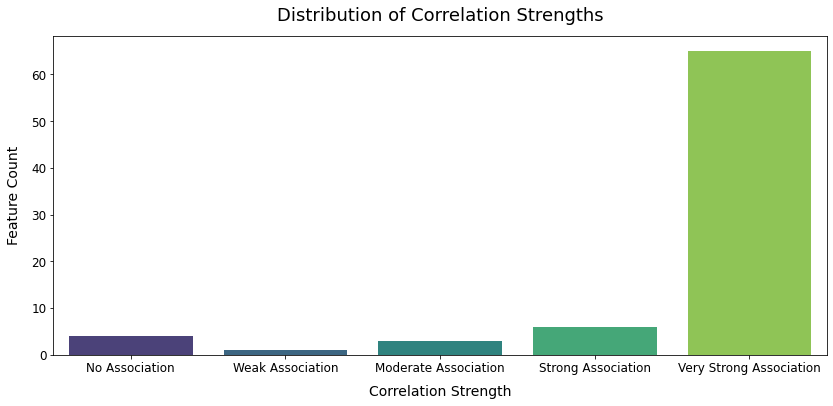

In [12]:
# Bar plot for distribution of correlation strength
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_corr, 
    x='Corr_Strength', 
    palette='viridis', 
    order=['No Association', 'Weak Association', 'Moderate Association', 'Strong Association', 'Very Strong Association']
)

# Customize plot aesthetics
plt.title("Distribution of Correlation Strengths", fontsize=18, pad=15)
plt.xlabel("Correlation Strength", fontsize=14, labelpad=10)
plt.ylabel("Feature Count", fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout(pad=2)
plt.show()


In [13]:
# Define the replacement values to remove
replace_terms = [
    '_RollingSum_1M',
    '_RollingAvg_1M',
    '_RollingSum_3M',
    '_RollingAvg_3M',
    '_RollingSum_6M',
    '_RollingAvg_6M',
    'AVGof'
]
# Replace the values in the 'Feature' column and create a new 'KPI' column
df_corr['KPI'] = df_corr['Feature']
for term in replace_terms:
    df_corr['KPI'] = df_corr['KPI'].str.replace(term, '', regex=False)
High_corr_Features = df_corr[(df_corr['Abs_Corr']>=0.5)&(df_corr['Feature']!=df_corr['KPI'])].reset_index(drop=True)
Low_corr_Features = df_corr[(df_corr['Abs_Corr']<0.5)&(df_corr['Feature']!=df_corr['KPI'])].reset_index(drop=True)

In [14]:
print(f"Number  of {df_corr[df_corr['Abs_Corr']>=0.5].shape[0]} Feature showed Strong or Higher Correlation")

df_corr[df_corr['Abs_Corr']>=0.5].head(20) 

Number  of 71 Feature showed Strong or Higher Correlation


,Feature,Corr,Abs_Corr,Method_Used,Corr_Strength,KPI
0,Total_Lost,1.000000,1.000000,Spearman,Very Strong Association,Total_Lost
1,Scheduled,0.885439,0.885439,Spearman,Very Strong Association,Scheduled
2,Worked,0.869834,0.869834,Spearman,Very Strong Association,Worked
3,Absence,0.856232,0.856232,Spearman,Very Strong Association,Absence
4,Early,0.855741,0.855741,Spearman,Very Strong Association,Early
5,Sick,0.812157,0.812157,Spearman,Very Strong Association,Sick
6,Total_Lost_RollingSum_1M,0.781225,0.781225,Spearman,Very Strong Association,Total_Lost
7,Training_RollingSum_6M,0.779647,0.779647,Spearman,Very Strong Association,Training
8,AVGofTotal_Lost_RollingSum_6M,0.778188,0.778188,Spearman,Very Strong Association,Total_Lost
9,AVGofTotal_Lost_RollingSum_3M,0.778133,0.778133,Spearman,Very Strong Association,Total_Lost


In [15]:
print(f"Number  of {df_corr[df_corr['Abs_Corr']<0.5].shape[0]} Feature showed Moderate or lower Correlation")
df_corr[df_corr['Abs_Corr']<0.5].head(10)

Number  of 8 Feature showed Moderate or lower Correlation


,Feature,Corr,Abs_Corr,Method_Used,Corr_Strength,KPI
71,BreakLunch_RollingAvg_6M,0.371747,0.371747,Spearman,Moderate Association,BreakLunch
72,BreakLunch,0.360294,0.360294,Spearman,Moderate Association,BreakLunch
73,BreakLunch_RollingAvg_3M,0.307598,0.307598,Spearman,Moderate Association,BreakLunch
74,BreakLunch_RollingAvg_1M,0.251018,0.251018,Spearman,Weak Association,BreakLunch
75,Rest,-0.085667,0.085667,Spearman,No Association,Rest
76,Rest_RollingAvg_6M,-0.042318,0.042318,Spearman,No Association,Rest
77,Rest_RollingAvg_3M,-0.024464,0.024464,Spearman,No Association,Rest
78,Rest_RollingAvg_1M,-0.023723,0.023723,Spearman,No Association,Rest


# 📊 **Insights from Correlation Analysis**

---

## 🔍 **Key Observations**

As observed from the **table above** and the **heatmap below**:

- **Rest** and **BreakLunch**, two of our numerical variables, exhibit only **moderate or weak associations** with **Total Lost**.  
- However, key variables such as:
  - **Absence**
  - **Early**
  - **Late**  
  Show **relatively strong correlations** and play a **significant role** in explaining variations in **Total Lost**.

---

## 📈 **Handling Variables for Future Predictions**

Since **Absence**, **Early**, and **Late** will **NOT** be available in the **prediction dataset** for future dates, we must rely on their:

- **Rolling Measures:**
  - **Early (Rolling)**
  - **Late (Rolling)**
  - **Absence (Rolling)**
  - **Worked (Rolling)**

Additionally, the **Scheduled** value can be **directly utilized** as it will be **available for future days**.

---

## 🚫 **Excluding Low-Impact Variables**

From our correlation analysis, we identified that variables such as:

- **Rest before Shift**
- **BreakLunch**
- **Vacation**
- **Worked Overtime**  
…and their respective **rolling calculations** offer **limited predictive value** due to their **weak correlations**.

Hence, these variables will be **excluded from the model**.

---

## 🎯 **Refining the Feature Set**

We will focus on **numerical features** that:

- Provide **meaningful insights**  
- Contribute to **improving the model’s ability** to explain variations in **Absence**  

This selective approach helps in:

- ✅ **Enhancing Model Accuracy:**  
  By focusing on impactful variables, we improve the model’s **predictive power**.

- ✅ **Improving Interpretability:**  
  A leaner feature set ensures that the model remains **easy to understand** and **explain** to stakeholders.

---

> 💡 **Conclusion:**  
By refining our feature set in this way, we aim to **enhance the model’s accuracy** and **interpretability**, ensuring that **only impactful variables** are used for predicting **future Total Lost trends**.


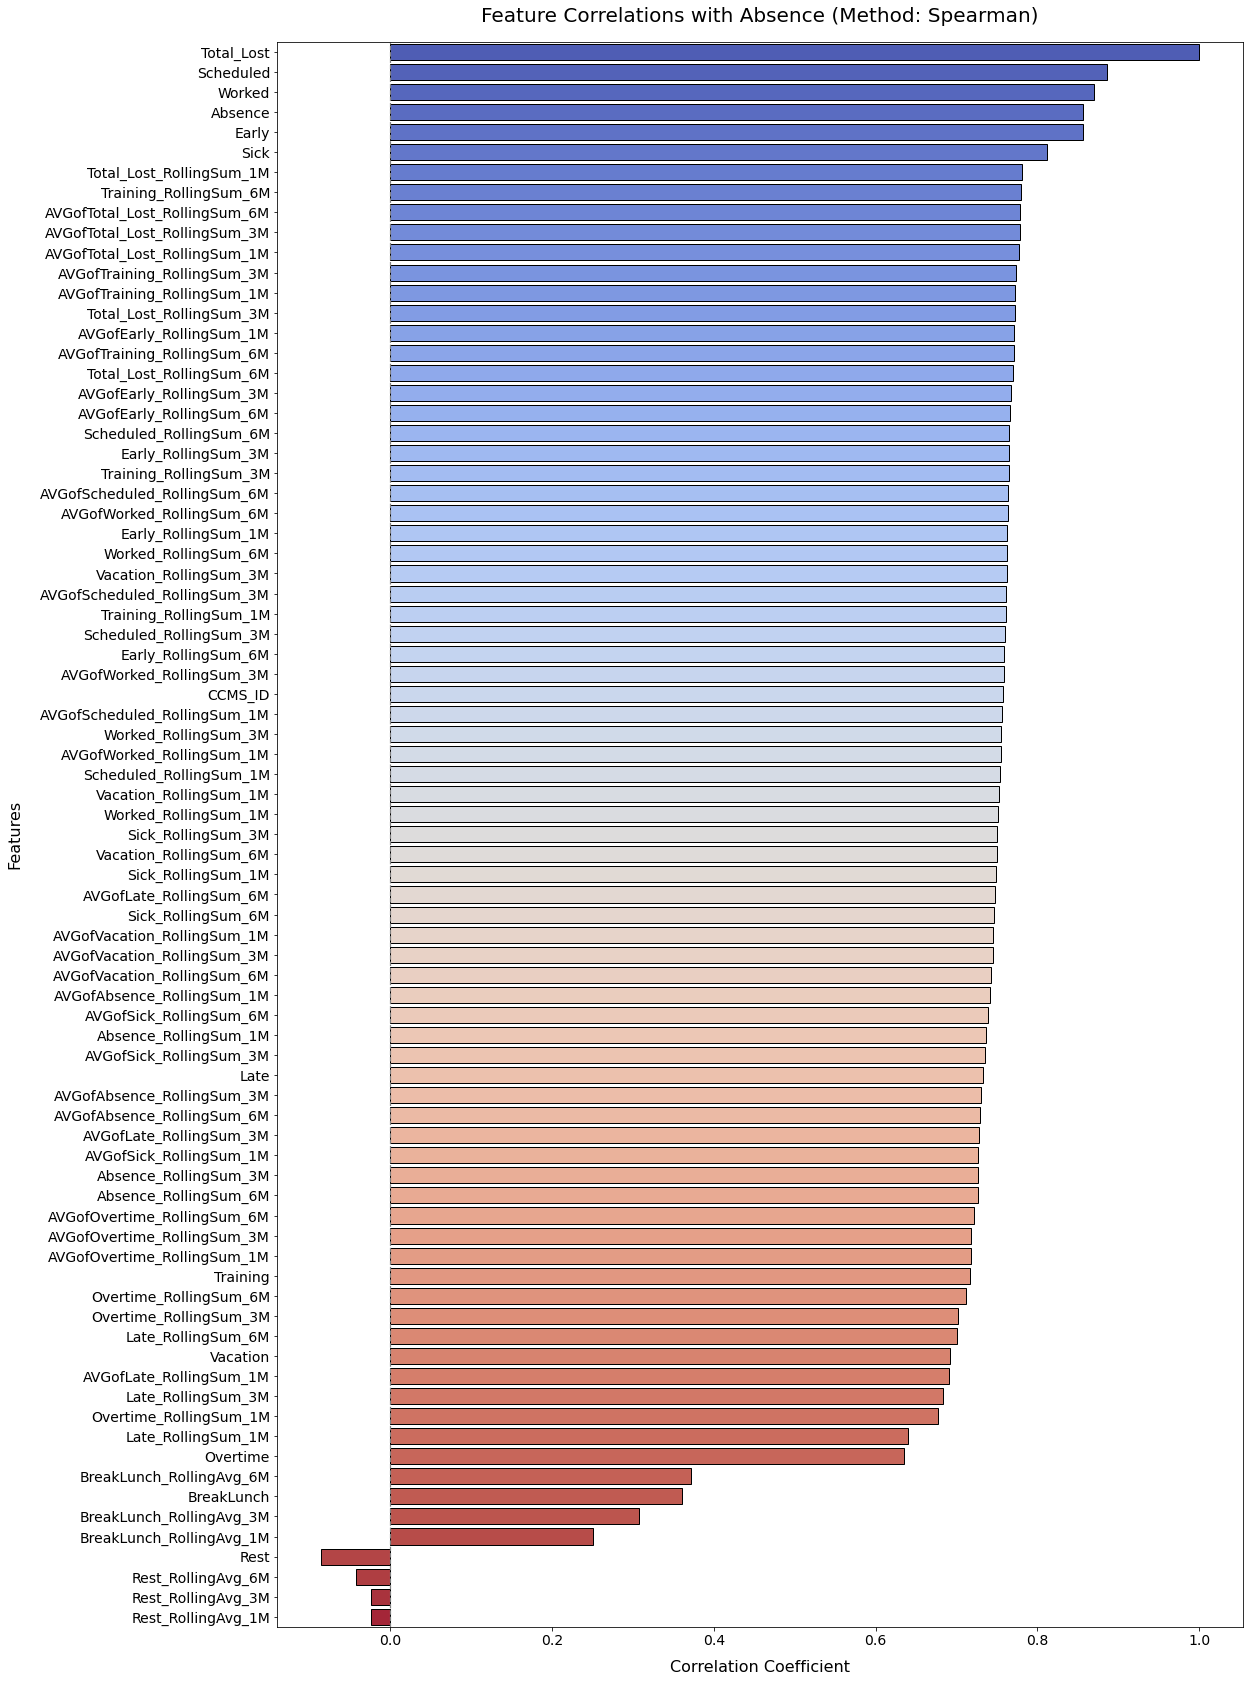

In [16]:
# Determine the correlation method used
method_used = df_corr['Method_Used'].iloc[0]  # Assuming all rows use the same method

# Adjusted bar plot for correlation values with increased features
plt.figure(figsize=(18, 24))  # Increased height and width for better visibility
sns.barplot(
    data=df_corr, 
    x='Corr', 
    y='Feature', 
    palette='coolwarm', 
    edgecolor='black'
)

# Customize plot aesthetics
plt.title(f"Feature Correlations with Absence (Method: {method_used})", fontsize=20, pad=20)  # Add method to title
plt.xlabel("Correlation Coefficient", fontsize=16, labelpad=12)  # Add padding to the x-label
plt.ylabel("Features", fontsize=16, labelpad=18)  # Add padding to the y-label
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Highlight neutral correlation (0 line)
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.2)

# Adjust layout for better spacing
plt.tight_layout(pad=3)
plt.show()


In [17]:
groupbycols = ['Date',
 'Year',
 'Season',
 'Month',
 'WeekofYear',
 'DayofMonth',
 'DayofWeek',
 'Is_Strike']
df['Is_Holiday'] = df['Is_Holiday'].astype(int)
df_grouped = df[df['Is_Actual']=='Actual'].groupby(groupbycols,as_index=False).agg(
                                          Is_Holiday=('Is_Holiday',np.mean)
                                         ,HC=('CCMS_ID','size')
                                         ,Scheduled =('Scheduled',np.sum)
                                         ,Worked =('Worked',np.sum)
                                         ,Overtime =('Overtime',np.sum)
                                         ,Training =('Training',np.sum)
                                         ,Vacation =('Vacation',np.sum)
                                         ,BreakLunch =('BreakLunch',np.sum)
                                         ,Sick =('Sick',np.sum)
                                         ,Total_Lost =('Total_Lost',np.sum)
                                         ,Absence =('Absence',np.sum)
                                         ,Early =('Early',np.sum)
                                         ,Late =('Late',np.sum)
                                         ).reset_index(drop=True)
df['Is_Holiday'] = df['Is_Holiday'].astype(str)
df_grouped['Date'] = pd.to_datetime(df_grouped['Date'])

df_grouped.describe().T


,count,mean,std,min,25%,50%,75%,max
Year,754.0,2023.546419,0.556115,2023.0,2023.0000,2024.000,2024.0000,2025.00
Season,754.0,2.456233,1.128559,1.0,1.0000,2.000,3.0000,4.00
Month,754.0,6.351459,3.529023,1.0,3.0000,6.000,9.0000,12.00
WeekofYear,754.0,25.732095,15.410793,1.0,12.0000,26.000,39.0000,52.00
DayofMonth,754.0,15.624668,8.775099,1.0,8.0000,16.000,23.0000,31.00
DayofWeek,754.0,2.996021,2.002319,0.0,1.0000,3.000,5.0000,6.00
Is_Strike,754.0,0.011936,0.108672,0.0,0.0000,0.000,0.0000,1.00
Is_Holiday,754.0,0.034483,0.182587,0.0,0.0000,0.000,0.0000,1.00
HC,754.0,235.380637,18.009432,210.0,221.0000,228.000,246.7500,279.00
Scheduled,754.0,1220.447825,539.286838,8.0,750.2500,1442.245,1581.0350,2034.00


# Seasonability

In [18]:
def decompose_absence(dfs, value_col='Total_Lost', samples='all', period=7):
    """
    Decompose a daily time series into trend, seasonality, and residuals.

    Parameters:
    -----------
    dfs : pandas.DataFrame
        Your daily dataframe (e.g. df_grouped) 
        with a 'Date' column of type datetime64[ns].
    value_col : str
        The name of the column you want to decompose (default 'Total_Lost').
    samples : int or 'all'
        How many recent samples (days) to use for decomposition.
        If 'all', use the entire time series.
    period : int
        The seasonality period. 
        For daily data with weekly seasonality, period=7.
        For monthly ~30, for yearly ~365, etc.
    """
    
    # Make a copy if you don't want to modify dfs in place
    df_copy = dfs.copy()
    
    # Ensure 'Date' is a DateTime index
    df_copy = df_copy.set_index('Date').sort_index()
    
    # Grab the series we want to decompose
    series = df_copy[value_col]
    
    # If we only want to decompose a portion of the data
    if samples != 'all':
        series = series.iloc[-samples:]  # last N samples
    
    # Perform seasonal decomposition
    result = seasonal_decompose(series, model='additive', period=period)
    
    # Extract the components
    observed = result.observed
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid
    
    # Plot the results
    fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    
    axs[0].set_title(f'Observed  Total Lost', fontsize=14)
    axs[0].plot(observed, label='Observed')
    axs[0].grid(True)
    
    axs[1].set_title(f'Trend Total Lost', fontsize=14)
    axs[1].plot(trend, color='orange', label='Trend')
    axs[1].grid(True)
    
    axs[2].set_title(f'Seasonality Total Lost', fontsize=14)
    axs[2].plot(seasonal, color='green', label='Seasonality')
    axs[2].grid(True)
    
    axs[3].set_title(f'Residual Total Lost', fontsize=14)
    axs[3].plot(residual, color='red', label='Residual')
    axs[3].scatter(x=residual.index, y=residual, alpha=0.5, color='red')
    axs[3].grid(True)
    
    plt.tight_layout()
    plt.show()

# Decompose weekly seasonality (period=7) & ACF & PACF Analysis

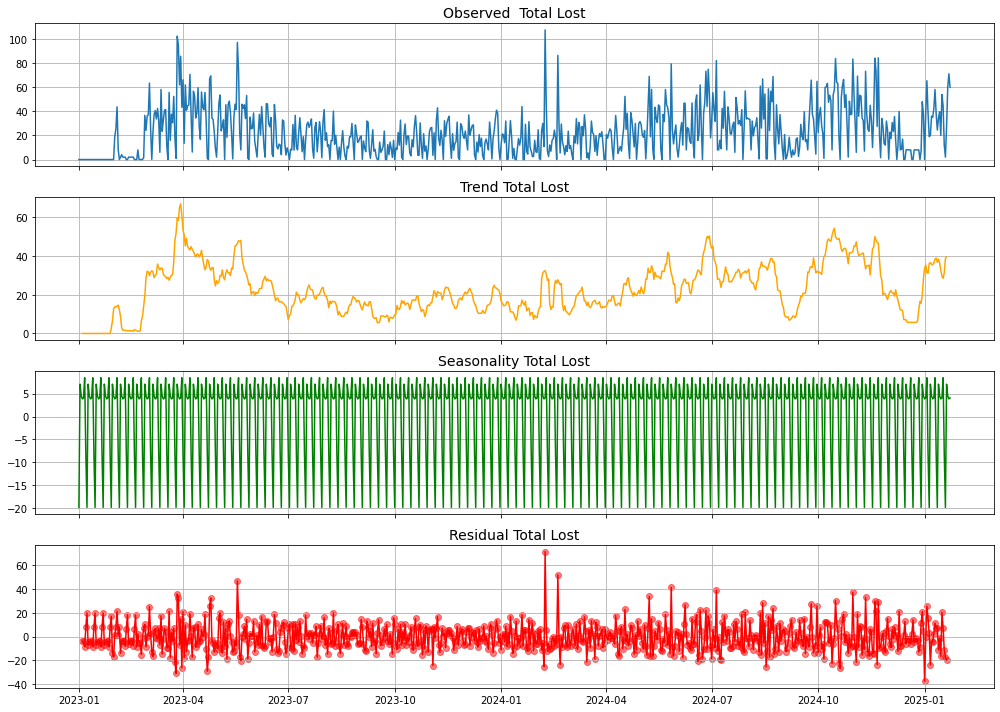

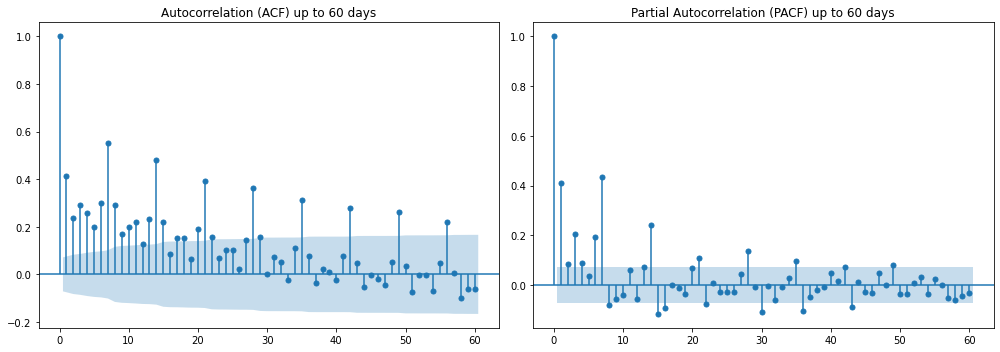

In [19]:
# 1) Decompose weekly seasonality (period=7)
decompose_absence(df_grouped, value_col='Total_Lost', samples='all', period=7)

# 2) Plot ACF and PACF side by side for up to 60 lags (about 2 months)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df_grouped['Total_Lost'], lags=60, ax=ax1)
ax1.set_title('Autocorrelation (ACF) up to 60 days')

plot_pacf(df_grouped['Total_Lost'], lags=60, ax=ax2)
ax2.set_title('Partial Autocorrelation (PACF) up to 60 days')

plt.tight_layout()
plt.show()

# 📊 **1. Decomposition Analysis**

### 🔍 **Observed:**
- Our **daily Total Losts series** shows considerable variation:
  - **Spikes**: Total Losts values occasionally spike between **80–100**.
  - **Baseline**: Fluctuates around **20–40** over extended periods.

### 📈 **Trend:**
- The **Trend line** gradually **rises and falls** over several months, suggesting:
  - **Long-term drift** possibly influenced by:
    - **Business cycles**
    - **Policy changes**
    - **Workforce dynamics**

### 🔄 **Seasonality (Period = 7):**
- The **green seasonality plot** forms a repeating wave **every 7 days**, indicating a **weekly pattern**.
- **Amplitude** ranges from roughly **+5 down to −15**, implying:
  - Certain **days of the week** consistently have **higher or lower** Total Losts rates.

### 📉 **Residual:**
- The **red scatter/line** represents what's left after removing **Trend** and **Seasonality**:
  - **Fluctuates** between **−40 and +40**, with some **extreme spikes**.
  - Indicates the presence of **additional drivers**, such as:
    - **Holidays**
    - **One-off events**
    - **Group-specific factors** that aren't captured by a simple weekly seasonality.

---

## ✅ **Key Takeaway:**
- We observe a clear **weekly seasonality** (**7-day cycle**).
- There’s also a noticeable **long-term trend**.
- Our future models should account for both using:
  - **Seasonal terms**
  - **Dummy variables for the day of the week**
  - **Other time-based features**

---

# 📊 **2. ACF & PACF Analysis**

We plotted the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** for **lags = 60** (covering ~2 months).

### 🔗 **ACF (Autocorrelation Function):**
- **Lag 1**: A **large spike**, indicating that **today’s Total Losts strongly correlate** with **yesterday’s**.
- **Weekly Pattern**: Noticeable spikes at **lags 7, 14, 21**, etc., confirming the **weekly pattern**.
- **Monthly Effect?**: Smaller spikes around **30 days** may suggest a **monthly trend** (less pronounced but worth exploring).

### 🔗 **PACF (Partial Autocorrelation Function):**
- **Lag 1**: The **largest spike**, highlighting a **strong direct correlation** with the **previous day’s Total Losts**.
- **Lag 7**: Another notable spike, showing a **weekly effect** beyond just the day-to-day correlation.
- **Higher Lags (14, 21, 28)**: Smaller spikes, suggesting that once we account for **lag 1** and **lag 7**, additional multiples of 7 add **less explanatory power**.

---

### 📈 **In General:**
- If **ACF remains high** at lags like **14, 21, 28**, but **PACF is low**, it implies that these correlations are **indirectly explained** by **lag 1** or **lag 7**.
- Spikes around **30 days** hint at potential **monthly patterns**, although **weekly trends** often dominate in business contexts.

---

## ✅ **Key Takeaway:**
- The time series has a strong **autoregressive structure**:
  - Depends on **past values**, especially **1 day ago** and **7 days ago**.
- We can enhance model performance by introducing **lagged features** such as:
  - **Total Losts_{t-1}** (previous day)
  - **Total Losts_{t-7}** (previous week)
  - Potentially **Total Losts_{t-14}**, **Total Losts_{t-30}**, if data shows benefits.

---

# 💡 **Final Thoughts**

### ✅ **Key Conclusions:**
- **Lag Features Are Applicable:**  
  ACF and PACF confirm that **past Total Losts values** help predict **future Total Losts**.

- **Critical Lags Identified:**
  - **Lag 1** (yesterday’s Total Losts)
  - **Lag 7** (Total Losts from the same day last week)
  - Potentially **Lag 14** or **Lag 30**, depending on model performance.

- **Seasonality Confirmed:**  
  Seasonal decomposition reaffirms a **weekly pattern**.

### 🔍 **Next Steps for Modeling:**
- Introduce **lag features**, particularly **day 1** and **day 7**.
- Consider adding:
  - **Explicit day-of-week features**
  - A **7-day seasonal term** for time-series models that support seasonality.

> 🚀 **In summary:**  
Introducing these lag features can significantly **improve predictive accuracy**, ensuring the model captures both **short-term dependencies** and **long-term seasonal trends**.


# Decomposemonthly seasonality (period=30) & ACF & PACF Analysis

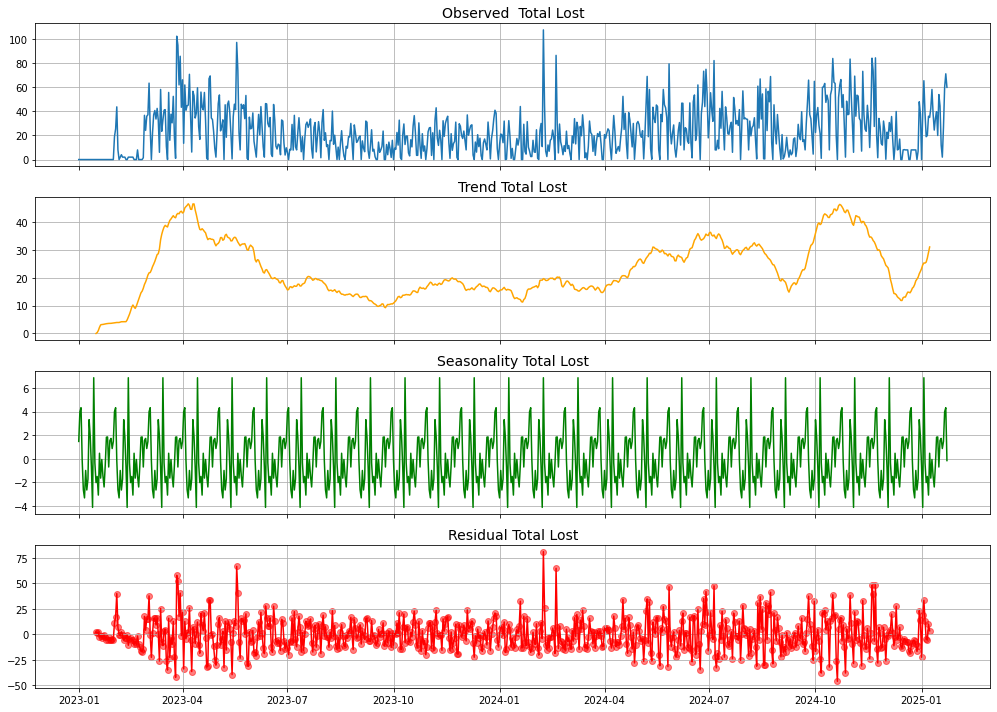

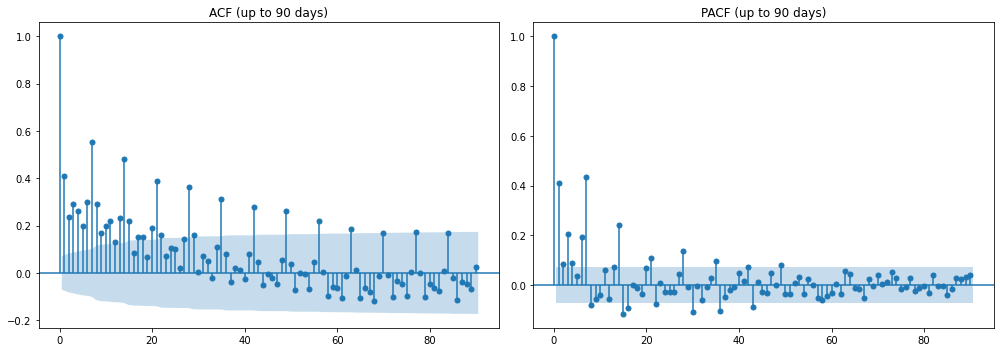

In [20]:
# 1) Decompose monthly seasonality (period=30)
decompose_absence(dfs=df_grouped,  # or whatever your DataFrame is named
                  value_col='Total_Lost',
                  samples='all',
                  period=30)  # approximate 1-month cycle

# 2) Plot ACF and PACF side by side for up to 90 lags (~3 months)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df_grouped['Total_Lost'], lags=90, ax=ax1)
ax1.set_title('ACF (up to 90 days)')

plot_pacf(df_grouped['Total_Lost'], lags=90, ax=ax2)
ax2.set_title('PACF (up to 90 days)')

plt.tight_layout()
plt.show()

# 📊 **1. Decomposition Analysis (Period = 30)**

---

### 🔍 **Observed (Total Losts)**
- The **daily Total Losts data** continues to show **significant variability**:
  - **Spikes** near **100** and periods closer to **0–20**.
- Compared to the **weekly decomposition**:
  - The **overall shape remains the same** (as it’s the same dataset).
  - Now focusing on extracting a **30-day repeating cycle**.

---

### 📈 **Trend**
- The **orange trend line** reveals a **long-term, slowly varying pattern**:
  - **Rises** from near **0 to around 40**.
  - Gradually **declines** toward the end of the series.
- This suggests influences from:
  - **External factors** (e.g., policy changes, business trends).
  - **Seasonal workforce dynamics** or **general workforce behavior** over **months**.

---

### 🔄 **Seasonality (Period ≈ 30 Days)**
- The **green line** attempts to capture a **monthly pattern**:
  - A **wave repeats** approximately every **30 data points**.
  - **Amplitude** ranges from about **+5 down to −1 or −2**, indicating:
    - Certain **days of the month** systematically show **higher/lower Total Losts** rates.

#### 🔍 **Comparison with Weekly Analysis:**
- The **weekly amplitude** was **larger (±15)**.
- The **monthly amplitude** is **smaller** but **still visible**.

---

### 📉 **Residual**
- After removing the **30-day seasonality** and **trend**, the **residual (in red)** shows:
  - **Notable spikes** ranging from **−40 to +80**.
- This indicates that:
  - A simple **30-day cycle doesn’t fully explain** daily fluctuations.
  - There are likely **other influences** such as:
    - **Weekly effects** (day-of-week patterns are strong).
    - **Holidays** and **random events**.

---

# 📊 **2. ACF & PACF Analysis (Up to 90 Days)**

---

### 🔗 **ACF (Autocorrelation Function)**
- **Lag 1:** A **large spike**, showing a **strong correlation** with **yesterday’s Total Losts**.
- **Weekly Patterns:** Ongoing spikes at multiples of 7 (**lags 7, 14, 21, etc.**), confirming the **weekly cycle**.
- **Monthly Signals:** Moderate spikes near **30, 60, and 90 days** hint at **monthly correlations**, though **less pronounced** compared to weekly lags.

---

### 🔗 **PACF (Partial Autocorrelation Function)**
- **Lag 1:** The **dominant direct effect**, meaning most of the correlation is with the **previous day’s Total Losts**.
- **Lag 7:** Shows significance, consistent with the **weekly pattern**.
- **Lag 30:** The **partial autocorrelation** is **smaller**, suggesting:
  - Once accounting for **shorter lags** (especially lag 1 and lag 7), the **monthly effect** adds **less direct explanatory power**.

#### 💡 **Key Insight:**
- **ACF** shows evidence of a **monthly cycle**.
- **PACF** suggests this monthly effect might be **indirect**, influenced by **weekly patterns** or other variables.

---

# ✅ **3. Key Takeaways for Monthly Seasonality**

### 📊 **Insights:**
- There **is** a **monthly signal**, but it’s **weaker** compared to the **weekly effect**.
- **Residual noise** remains **substantial** after accounting for the 30-day cycle, indicating **stronger drivers** (like weekly patterns).

---

### 🔍 **ACF vs. PACF:**
- **Minor correlation spikes** near **30 days** in the ACF.
- **PACF** for those lags is **not as large**, implying the monthly pattern may be **partly indirect**:
  - **Monthly patterns** might result from **accumulated weekly effects** or **external variables**.

---

### ❓ **Should We Use a Monthly Lag?**
- **Yes**, we can consider including **`Total Losts_{t-30}`** as a feature.
- However, the data strongly suggests that:
  - **Weekly lags** (**`t-7`**) and **lag 1** are **more critical**.
- Given:
  - **12+ months of data**
  - **Business relevance** (e.g., payroll, scheduling, monthly reporting deadlines)
  
Adding a **monthly seasonal component** or **monthly lags** could help, but it’s essential to **experiment** and assess if it **meaningfully improves model accuracy** compared to using only **weekly or daily lags**.

---

# 📊 **4. Overall Conclusion**

---

### 📈 **Comparing Monthly vs. Weekly Decomposition:**
- **Weekly patterns** and **short-term lags** (**1 day**, **7 days**) are **more dominant** in both:
  - **Seasonal decomposition**
  - **ACF/PACF analysis**
  
- **Monthly seasonality** exists but is **less pronounced**.
  - We may capture this with a **30-day lag**.

---

### 🚀 **Modeling Plan:**
- Start with **lagged features**:
  - **`Total Losts_{t-1}`**
  - **`Total Losts_{t-7}`**
  - Possibly **`Absence_{t-14}`**
- Test whether adding:
  - **`Total Losts_{t-30}`**
  - **Monthly dummies**  
  Yields any **performance improvement**.

---

> 💡 **Final Thought:**  
While **weekly patterns** dominate, exploring **monthly lags** could uncover subtle trends, especially in business contexts where **monthly cycles matter**. Continuous **testing and validation** will determine their true **predictive value**. 🚀


In [21]:
#### Filter by Date & Select Columns

# df_grouped = df_grouped[df_grouped['Date']<='2025-01-01']

test_columns = ['Date',
 'Year',
 'Season',
 'Month',
 'WeekofYear',
 'DayofMonth',
 'DayofWeek',
 'Is_Holiday',
 'Is_Strike',
 'HC',
 'Scheduled',
 'Total_Lost',
 'Absence',
 'Early',
 'Late']
df_grouped_test = df_grouped[test_columns].copy()
df_grouped_test['Is_Holiday'] = df_grouped_test['Is_Holiday'].astype(int)

# 1) Convert to DateTime if it isn't already
df_grouped_test['Date'] = pd.to_datetime(df_grouped_test['Date'])

# 2) Set the index to the Date
df_grouped_test = df_grouped_test.set_index('Date')

# We'll overwrite them to be 100% sure they match the index
df_grouped_test['Year']       = df_grouped_test.index.year
df_grouped_test['Month']      = df_grouped_test.index.month
df_grouped_test['DayofMonth'] = df_grouped_test.index.day
df_grouped_test['DayofWeek']  = df_grouped_test.index.dayofweek  # Monday=0, Sunday=6
df_grouped_test['WeekofYear'] = df_grouped_test.index.isocalendar().week  # returns 1..53


# Scenario A: Modeling Without Lags

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's l2: 9.93353
R-squared (R2) score: 0.972
Mean Squared Error (MSE): 9.934
Mean Absolute Error (MAE): 1.350
Root Mean Squared Error (RMSE): 3.152
Average of Actual Total_Lost: 23.145
Average of Predictions Total_Lost: 22.748


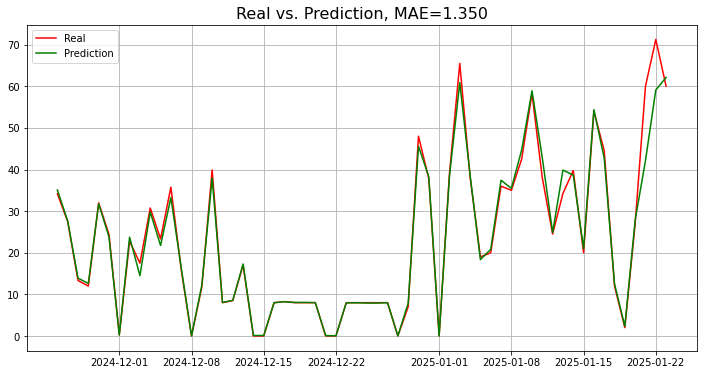

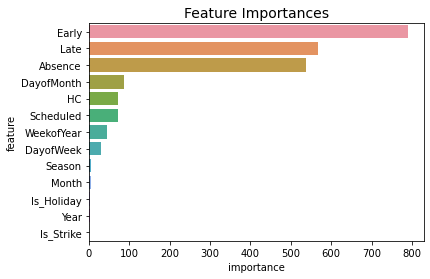

MAE without lags = 1.350


In [22]:

def train_time_series(df, target='Total_Lost', horizon=30):
    """
    Trains an LGBMRegressor on time series data, splitting the last `horizon` rows as the test set.
    """
    # 1) Separate features and target
    X = df.drop(columns=[target])
    y = df[target]
    
    # 2) Split train/test by last 'horizon' rows
    X_train, X_test = X.iloc[:-horizon, :], X.iloc[-horizon:, :]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    # 3) Train LGBM with tuned hyperparameters and early stopping
    model = LGBMRegressor(
        random_state=42, 
        learning_rate=0.05, 
        n_estimators=1000, 
        max_depth=7, 
        num_leaves=31,
        verbose=-1  # Suppress LightGBM output
    )
    
    # Use early stopping
    model.fit(
        X_train, y_train, 
        eval_set=[(X_test, y_test)], 
        callbacks=[early_stopping(stopping_rounds=50, verbose=-1)]
    )
    
    # 4) Predict on test
    preds = model.predict(X_test)
    
    # 5) Calculate MAE
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    # 6) Print evaluation metrics and averages
    print(f"R-squared (R2) score: {r2:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"Average of Actual Total_Lost: {y_test.mean():.3f}")
    print(f"Average of Predictions Total_Lost: {preds.mean():.3f}")
    
    # 7) Plot Real vs Prediction
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Real', color='red')
    plt.plot(y_test.index, preds, label='Prediction', color='green')
    plt.title(f"Real vs. Prediction, MAE={mae:.3f}", fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()
    
    # 8) Feature importances
    feat_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    plt.title("Feature Importances", fontsize=14)
    sns.barplot(x='importance', y='feature', data=feat_imp, orient='h')
    plt.show()
    
    return model, mae

# Run the model
model_no_lags, mae_no_lags = train_time_series(df=df_grouped_test, target='Total_Lost', horizon=60)
print(f"MAE without lags = {mae_no_lags:.3f}")


# Scenario B: Create Lags & Model With Lags

Now we’ll add weekly (lag=7) and monthly (lag=30) lags for Absence, Early, and Late, just like you mentioned. Then we’ll repeat the train/test approach.

Shape after adding lags and dropping NaNs: (724, 22)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's l2: 8.15827
R-squared (R2) score: 0.977
Mean Squared Error (MSE): 8.158
Mean Absolute Error (MAE): 1.253
Root Mean Squared Error (RMSE): 2.856
Average of Actual Total_Lost: 23.145
Average of Predictions Total_Lost: 22.887


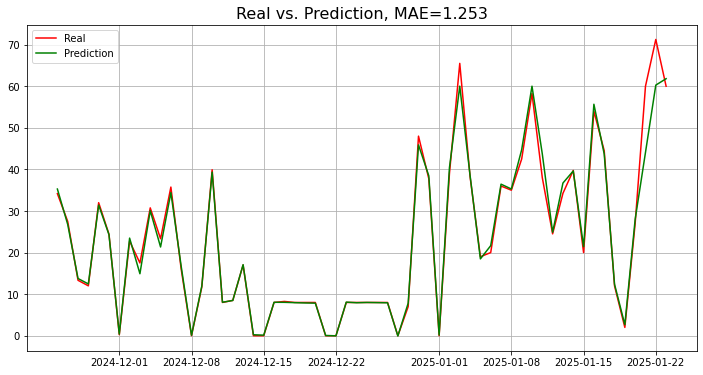

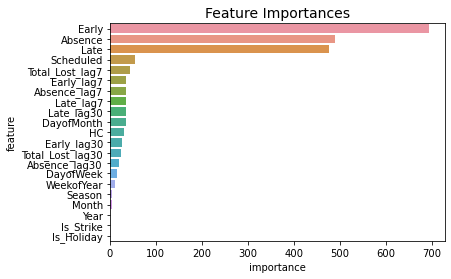

MAE with lags = 1.253


In [23]:
df_with_lags = df_grouped_test.copy()

# Create weekly lag (7 days) and monthly lag (30 days) for Absence, Early, Late


df_with_lags['Total_Lost_lag7']  = df_with_lags['Total_Lost'].shift(7)
df_with_lags['Total_Lost_lag30'] = df_with_lags['Total_Lost'].shift(30)

df_with_lags['Absence_lag7']  = df_with_lags['Absence'].shift(7)
df_with_lags['Absence_lag30'] = df_with_lags['Absence'].shift(30)

df_with_lags['Early_lag7']    = df_with_lags['Early'].shift(7)
df_with_lags['Early_lag30']   = df_with_lags['Early'].shift(30)

df_with_lags['Late_lag7']     = df_with_lags['Late'].shift(7)
df_with_lags['Late_lag30']    = df_with_lags['Late'].shift(30)

# Drop rows that became NaN due to shifting (first 30 days)
df_with_lags.dropna(axis=0, how='any', inplace=True)

print("Shape after adding lags and dropping NaNs:", df_with_lags.shape)

# Re-run train_time_series
model_with_lags, mae_with_lags = train_time_series(df=df_with_lags, 
                                                   target='Total_Lost',
                                                   horizon=60)

print(f"MAE with lags = {mae_with_lags:.3f}")

# 📊 **Model Performance and Readiness for Testing**

---

## ✅ **Key Observations**

Based on the observed **Mean Absolute Error (MAE)** and **feature importance analysis**, it is evident that:

- **Introducing lagged columns** has significantly **improved the model’s performance**, particularly in terms of:
  - **Feature relevance**
  - **Predictive power**

### 🔄 **Why Lagged Features Matter:**
- They provide **valuable context** by capturing **temporal patterns** and **trends**.
- This is essential for accurate **time series forecasting** as they:
  - Reflect **short-term dependencies** (e.g., yesterday’s absence).
  - Capture **seasonal effects** (e.g., weekly or monthly cycles).

---

## 🚀 **Readiness for Testing Phase**

Given the **enhanced model performance** with the inclusion of lag features, we are now ready to proceed to the:

- **Testing Phase** for **Absence predictions**.
- Ensuring that the model delivers **robust** and **reliable results**.

---

## ⚠️ **Important Note**

- The model currently demonstrates a **very high R² value** with **acceptable performance** because we **retained the following measures** in our dataset:
  - **Absence**
  - **Early**
  - **Late**

- These variables were included to **explore seasonality** during the **model development phase**.

### ❗ **Impact of Removing Absence, Early, and Late:**
- When these measures are **removed**:
  - The model’s performance **declines significantly**, especially in:
    - **R² score**
    - Other **evaluation metrics** (e.g., MAE, RMSE)
- This highlights the **critical role** these variables play in **capturing seasonality** and explaining **variations in absenteeism**.

---

## ⚙️ **Approach for Model Experimentation**

- For the **model experimentation process**, we will:
  - Use a **well-adjusted dataset** tailored for both **training** and **testing**.
  - Ensure that the dataset:
    - Maintains **relevant lagged features**.
    - Is structured to **balance performance** while minimizing dependence on unavailable future data.

---

> 💡 **Final Thought:**  
The **lagged features** have proven to be **crucial** for capturing temporal dependencies. Moving forward, we will focus on **refining** the dataset and **evaluating** the model’s robustness in different scenarios to ensure **consistent** and **accurate absenteeism predictions**. 🚀


In [24]:

#############
df['Strike'] = df['c_name_y'].str.contains('Strike', na=False).astype(int)
df['Waha']=df['Location Type'].str.contains('WAHA', na=False).astype(int)
df['Is_Holiday'] = df['Is_Holiday'].astype(int)
df['Is_Strike'] = df['Is_Strike'].astype(int)
#######
def prepare_dataframe(df,  mu_name='All'):
    groupbycols = [
        'Date', 'Year', 'Season', 'Month', 'WeekofYear',
        'DayofMonth', 'DayofWeek', 'Is_Strike'
    ]

    # Step 1: Filter the dataframe
    dfprep = df[df['Is_Actual'] == 'Actual']

    if  mu_name != 'All':
        dfprep = dfprep[(dfprep['MU_Name'] == mu_name)]

    # Step 2: Groupby and aggregate
    dfprep = dfprep.groupby(groupbycols, as_index=False).agg(
        Is_Holiday=('Is_Holiday', np.mean),  # Avg holiday % across countries
        HC=('CCMS_ID', 'size'),              # Headcount
        StrikeP=('Strike', np.mean),          # Strike participation %
        Waha=('Waha', np.mean),               # Waha employee %
        Scheduled=('Scheduled', np.sum),      # Scheduled hours sum
        Worked=('Worked', np.sum),            # Worked hours sum
        Overtime=('Overtime', np.sum),        # Overtime hours sum
        Training=('Training', np.sum),        # Training hours sum
        Vacation=('Vacation', np.sum),        # Vacation hours sum
        Sick=('Sick', np.sum),                # Sick hours sum
        Total_Lost=('Total_Lost', np.sum),    # Total lost = Absence + Early + Late
        Absence=('Absence', np.sum),          # Absence hours sum
        Early=('Early', np.sum),              # Early leaving hours sum
        Late=('Late', np.sum)                 # Late arrivals sum
    ).reset_index(drop=True)

    # Step 3: Define columns for rolling sums
    rolling_columns = ['Total_Lost', 'Absence', 'Early', 'Late','Scheduled', 'Worked', 'Training', 'Vacation', 'Sick']

    # Step 4: Define rolling windows
    rolling_windows = {
        '1W': 7,    # Last 1 week
        '1M': 30,   # Last 1 Month
    }

    # Step 5: Sort by date before rolling calculations
    dfprep = dfprep.sort_values(by=['Date'])

    # Step 6: Compute rolling sums with 1-week delay
    for window_label, window_size in rolling_windows.items():
        for col in rolling_columns:
            dfprep[f'{col}_RollingSum_{window_label}'] = (
                dfprep[col].shift(7)  # Shift by 7 days to delay calculation
                .rolling(window=window_size, min_periods=1)
                .sum()
                .reset_index(drop=True)
            )
    # Step 6: Compute rolling AVG with 1-week delay
    for window_label, window_size in rolling_windows.items():
        for col in rolling_columns:
            dfprep[f'{col}_RollingAVG_{window_label}'] = (
                dfprep[col].shift(7)  # Shift by 7 days to delay calculation
                .rolling(window=window_size, min_periods=1)
                .mean()
                .reset_index(drop=True)
            )
    # Step 7: Convert 'Date' to datetime and set index
    dfprep['Date'] = pd.to_datetime(dfprep['Date'])
    dfprep = dfprep.set_index('Date')

    # Step 8: Overwrite columns based on index
    dfprep['Year'] = dfprep.index.year
    dfprep['Month'] = dfprep.index.month
    dfprep['DayofMonth'] = dfprep.index.day
    dfprep['DayofWeek'] = dfprep.index.dayofweek  # Monday=0, Sunday=6
    dfprep['WeekofYear'] = dfprep.index.isocalendar().week

    # Step 9: Create lagged features
    lag_days = [7,30]
    for lag in lag_days:
        for col in ['Scheduled', 'Worked','Total_Lost', 'Absence', 'Early', 'Late', 'Training', 'Vacation', 'Sick']:
            dfprep[f'{col}_lag{lag}'] = dfprep[col].shift(lag)

    # Step 10: Drop rows with NaN values introduced by shifting
    dfprep.dropna(axis=0, how='any', inplace=True)

    # Step 11: Drop unnecessary columns
    drop_cols = ['Absence', 'Early', 'Late', 'Worked', 'Training', 'Vacation', 'Sick','Overtime',]
    dfprep.drop(columns=drop_cols, inplace=True)
    
    dfprep['Month_sin'] = np.sin(2 * np.pi * dfprep['Month'] / 12)
    dfprep['Month_cos'] = np.cos(2 * np.pi * dfprep['Month'] / 12)
    dfprep['DayofWeek_sin'] = np.sin(2 * np.pi * dfprep['DayofWeek'] / 7)
    dfprep['DayofWeek_cos'] = np.cos(2 * np.pi * dfprep['DayofWeek'] / 7)
    dfprep['DayofMonth_sin'] = np.sin(2 * np.pi * dfprep['DayofMonth'] / 31)
    dfprep['DayofMonth_cos'] = np.cos(2 * np.pi * dfprep['DayofMonth'] / 31)

    
    return dfprep

# Example usage with default 'All' filters
processed_df = prepare_dataframe(df)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's l2: 242.982
R-squared (R2) score: 0.368
Mean Squared Error (MSE): 242.982
Mean Absolute Error (MAE): 13.931
Root Mean Squared Error (RMSE): 15.588
Average of Actual Total_Lost: 38.964
Average of Predictions Total_Lost: 36.791


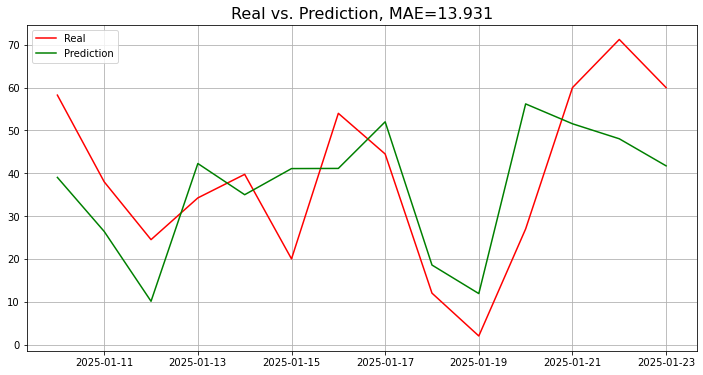

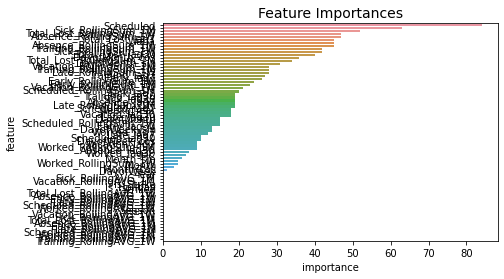

MAE with lags = 13.931


In [25]:
# Re-run train_time_series
model_with_lags, mae_with_lags = train_time_series(df=processed_df, 
                                                   target='Total_Lost',
                                                   horizon=14)

print(f"MAE with lags = {mae_with_lags:.3f}")